In [ ]:
!pip install kagglehub lime

In [29]:
# import
import kagglehub
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [30]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 53944), started 0:05:20 ago. (Use '!kill 53944' to kill it.)

In [31]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SUBSET_SIZE = 2000
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-4
SEED=42
NUM_WORKERS=2

In [32]:
np.random.seed(SEED)
torch.manual_seed(SEED)

In [33]:
# Download dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Dataset:", path)

Dataset: /home/lois/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [34]:
# Dataset loading
image_paths_dict = {}
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg'):
            image_id = os.path.splitext(file)[0]
            image_paths_dict[image_id] = os.path.join(root, file)

metadata_path = os.path.join(path, 'HAM10000_metadata.csv')

df = pd.read_csv(metadata_path)
df['path'] = df['image_id'].map(image_paths_dict.get)
df = df.dropna(subset=['path'])

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

# Encodage des labels (texte -> 0, 1, 2...)
le = LabelEncoder()
df['label'] = le.fit_transform(df['cell_type'])
NUM_CLASSES = len(le.classes_)


In [35]:
# Creation subset / dataset
if SUBSET_SIZE < len(df):
    df_subset = df.sample(n=SUBSET_SIZE, random_state=SEED).reset_index(drop=True)
else:
    df_subset = df

train_df, test_df = train_test_split(df_subset, test_size=0.2, stratify=df_subset['label'], random_state=SEED)
# Définition des transformations (Prétraitement pour ResNet)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), # Augmentation de données simple
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Classe Dataset PyTorch personnalisée
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(int(self.df.iloc[idx]['label']), dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

train_dataset = SkinDataset(train_df, transform=data_transforms['train'])
test_dataset = SkinDataset(test_df, transform=data_transforms['val'])
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [36]:
# Transfer Learning avec ResNet18
model = models.resnet18(pretrained=True)

for param in model.parameters(): # freeze all layers
    param.requires_grad = False

# Replace last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)


/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training
writer = SummaryWriter('runs/skin_cancer_experiment')
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        writer.add_scalar('Training/Batch_Loss', loss.item(), epoch * len(train_loader) + i)
    
    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader) 
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = 100 * correct_val / total_val
    val_loss /= len(test_loader)
    
    writer.add_scalars('Loss', {'Train': epoch_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': epoch_acc, 'Val': val_acc}, epoch)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
writer.close()

In [37]:
# Save model
torch.save(model.state_dict(), 'skin_lesion_resnet18.pth')

In [ ]:
# Load model
model_path = "models/skin_lesion_resnet18.pth"

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7) # 7 est le nombre de classes (NUM_CLASSES)
model = model.to(DEVICE)

# 2. Si votre variable 'model' actuelle contient le dictionnaire (ce qui cause l'erreur)
# On la renomme temporairement pour ne pas la perdre
weights_dict = torch.load(model_path, map) if os.path.exists(model_path) else model 

# 3. On charge les poids dans l'architecture
# Note : on utilise 'strict=False' au cas où il y a de petites différences, mais idéalement True
try:
    model.load_state_dict(weights_dict)
    print("Poids chargés avec succès dans le modèle !")
except Exception as e:
    print(f"Erreur lors du chargement des poids : {e}")
    print("Assurez-vous que 'weights_dict' est bien le state_dict.")

Poids chargés avec succès dans le modèle !


/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lois/Documents/mlbio/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Démarrage de LIME ---
Explication pour l'image 255. Classe réelle : Melanoma


100%|██████████| 2000/2000 [00:36<00:00, 54.32it/s]


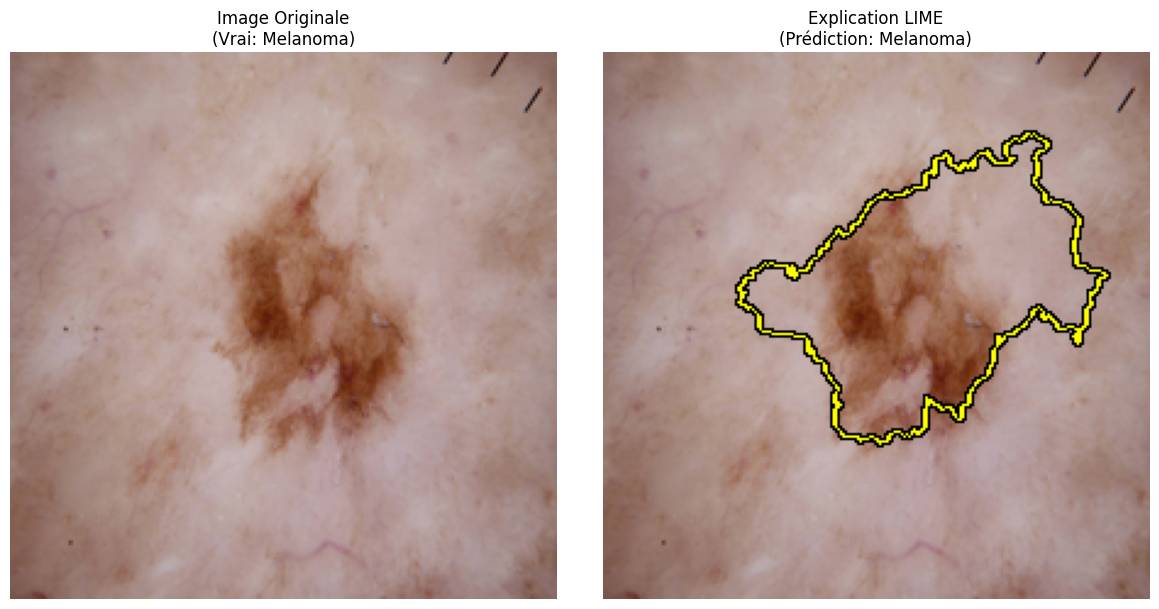

In [ ]:
# ==========================================
# 6. LIME EXPLANATION
# ==========================================

print("\n--- Démarrage de LIME ---")

def batch_predict(images):
    model.eval()
    batch = torch.stack([data_transforms['val'](Image.fromarray(i)) for i in images], dim=0)
    batch = batch.to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()

idx = np.random.randint(0, len(test_dataset))
img_tensor, label_idx = test_dataset[idx]
# On recharge l'image brute pour affichage
img_path = test_df.iloc[idx]['path']
img_numpy = np.array(Image.open(img_path).convert('RGB').resize((224, 224)))

print(f"Explication pour l'image {idx}. Classe réelle : {le.classes_[label_idx]}")

explanation = explainer.explain_instance(
    img_numpy, 
    batch_predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=10000
)
# ... (votre code LIME précédent reste le même jusqu'à 'explanation') ...

# Récupération de l'image et du masque
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False 
)

# --- CORRECTION DE L'AFFICHAGE ---
plt.figure(figsize=(12, 6))

# Image de gauche : Originale
plt.subplot(1, 2, 1)
plt.imshow(img_numpy)
plt.title(f"Image Originale\n(Vrai: {le.classes_[label_idx]})")
plt.axis('off')

# Image de droite : Explication LIME
plt.subplot(1, 2, 2)

# Astuce : On s'assure que l'image est bien entre 0 et 1 pour l'affichage
img_to_show = temp.copy()
if img_to_show.max() > 1:
    img_to_show = img_to_show / 255.0

# On affiche sans ajouter de luminosité artificielle (+ 0.5 retiré)
plt.imshow(mark_boundaries(img_to_show, mask, color=(1, 1, 0), outline_color=(0, 0, 0))) # Jaune avec contour noir
plt.title(f"Explication LIME\n(Prédiction: {le.classes_[explanation.top_labels[0]]})")
plt.axis('off')

plt.tight_layout()
plt.show()